## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

2024-02-22 17:23:43.492926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 17:23:43.493033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 17:23:43.621745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [5]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function. 

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [6]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448  

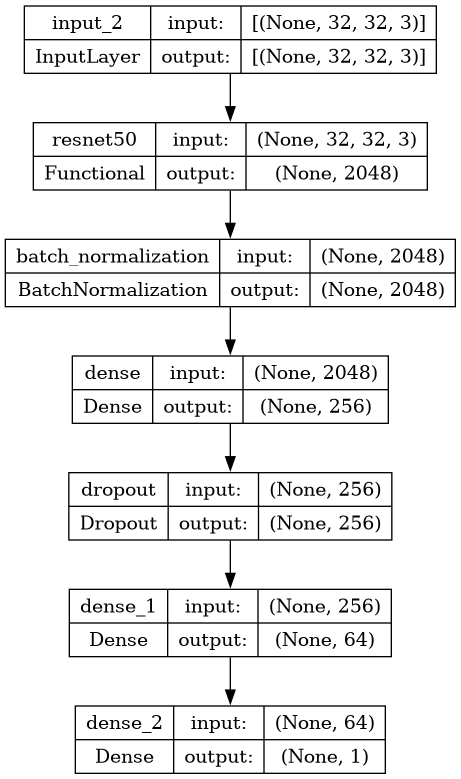

In [7]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [8]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/100


I0000 00:00:1708622949.334992      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 221s 873ms/step - loss: 1.7356 - accuracy: 0.9024 - precision: 0.8993 - recall: 0.9064 - val_loss: 3.4438 - val_accuracy: 0.5215 - val_precision: 0.5110 - val_recall: 0.9999
Epoch 2/100
200/200 [==============================] - 30s 144ms/step - loss: 0.3978 - accuracy: 0.9453 - precision: 0.9449 - recall: 0.9458 - val_loss: 0.3044 - val_accuracy: 0.9339 - val_precision: 0.9709 - val_recall: 0.8946
Epoch 3/100
200/200 [==============================] - 31s 150ms/step - loss: 0.2100 - accuracy: 0.9555 - precision: 0.9550 - recall: 0.9560 - val_loss: 0.2059 - val_accuracy: 0.9380 - val_precision: 0.9845 - val_recall: 0.8899
Epoch 4/100
200/200 [==============================] - 30s 144ms/step - loss: 0.1556 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - val_loss: 0.1945 - val_accuracy: 0.9482 - val_precision: 0.9731 - val_recall: 0.9220
Epoch 5/100
200/200 [==============================] - 30s 148ms/step - loss: 0.1327 - accuracy: 0.

In [9]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 7s 139ms/step - loss: 0.1429 - accuracy: 0.9590 - precision: 0.9626 - recall: 0.9551
Val Loss: 0.1429
Val Accuracy: 0.9590
Val Precision: 0.9626
Val Recall: 0.9551


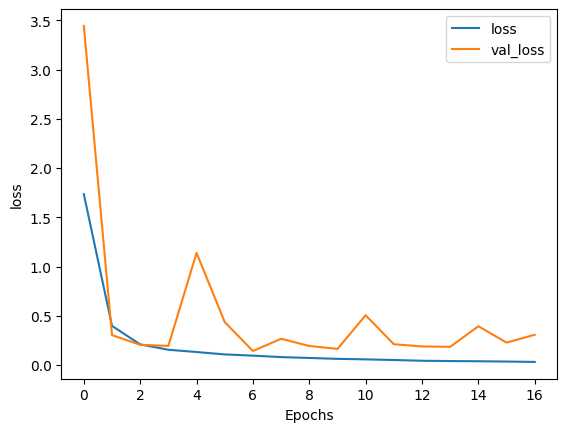

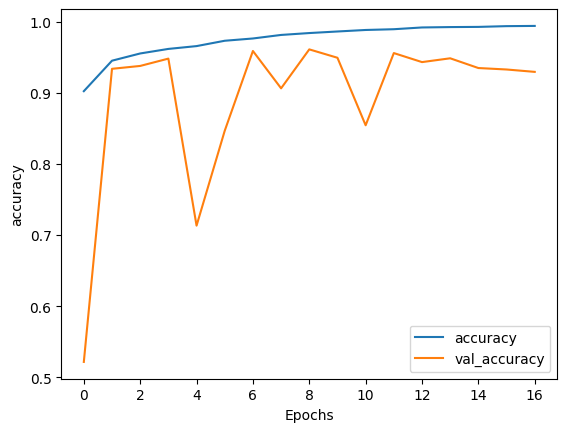

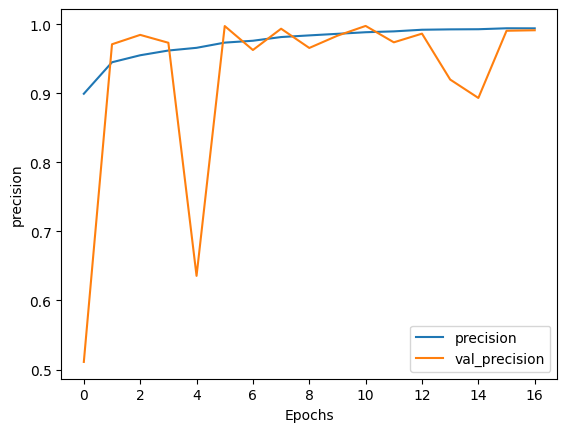

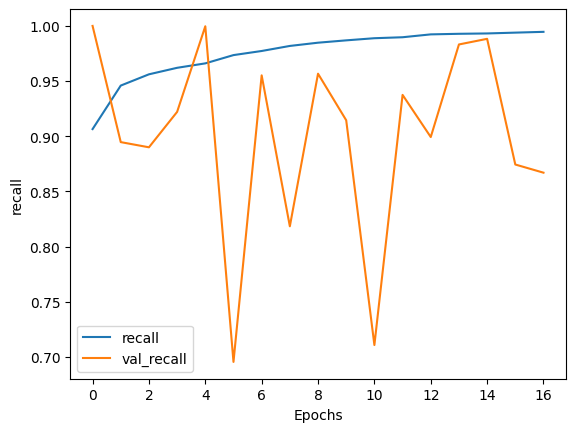

In [10]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')